In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow version: 2.2.0
GPU detected: []
/kaggle/input/ner-dataset/ner_datasetreference.csv


In [2]:
data = pd.read_csv('../input/ner-dataset/ner_datasetreference.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
data['Sentence #'].unique()

array(['Sentence: 1', 'Sentence: 2', 'Sentence: 3', ...,
       'Sentence: 47957', 'Sentence: 47958', 'Sentence: 47959'],
      dtype=object)

In [4]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [5]:
print("unique words; ",data["Word"].nunique())
print("unique tags; ",data["Tag"].nunique())

unique words;  35178
unique tags;  17


In [6]:
#creating dataset for unique words, tags
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))

In [7]:
np.shape(words)

(35179,)

In [8]:
num_words = len(words)
num_tags = len(tags)

In [9]:
num_words

35179

In [10]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_fun)
        self.sentences = [i for i in self.grouped]
    
    

In [11]:
getter = Sentence_getter(data)

In [12]:
sentences = getter.sentences

In [13]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [14]:
# Creating vocabulary
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [15]:
tag2idx

{'B-nat': 0,
 'B-eve': 1,
 'B-tim': 2,
 'I-nat': 3,
 'I-geo': 4,
 'I-art': 5,
 'I-per': 6,
 'B-geo': 7,
 'I-tim': 8,
 'I-org': 9,
 'B-art': 10,
 'O': 11,
 'I-eve': 12,
 'B-org': 13,
 'I-gpe': 14,
 'B-per': 15,
 'B-gpe': 16}

**Hist plot of len of sentences**

[]

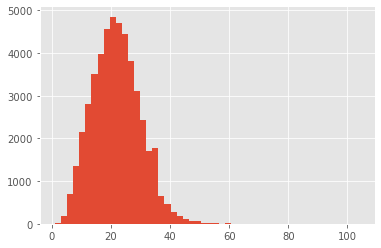

In [16]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.plot()

Lets take 50 as maxlen to be on safer side

Padding inputs to maxlen

Creating INPUTS AND OUTPUTS

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])


Converting output labes to categorical ( ONE_HOT )

In [18]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [19]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [20]:
x_train

NameError: name 'x_train' is not defined

Now train-test splitting

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=1 )

Building and compiling a BiLSTM

In [22]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [23]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

TRAINING MODEL with per-epoch visualizations using CALLBACKS

In [25]:
pip install livelossplot

     |████████████████████████████████| 496 kB 5.8 MB/s 
  Created wheel for tornado: filename=tornado-6.0.4-cp37-cp37m-linux_x86_64.whl size=428633 sha256=d373c18026df0cec22d4a604d1464993966671054c0bfd81d051eab83231cb37
  Stored in directory: /root/.cache/pip/wheels/7d/14/fa/d88fb5da77d813ea0ffca38a2ab2a052874e9e1142bad0b348
Successfully built tornado
ERROR: jupyterlab-git 0.10.0 has requirement nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
Note: you may need to restart the kernel to use updated packages.


In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras


In [27]:
type(y_train)

list

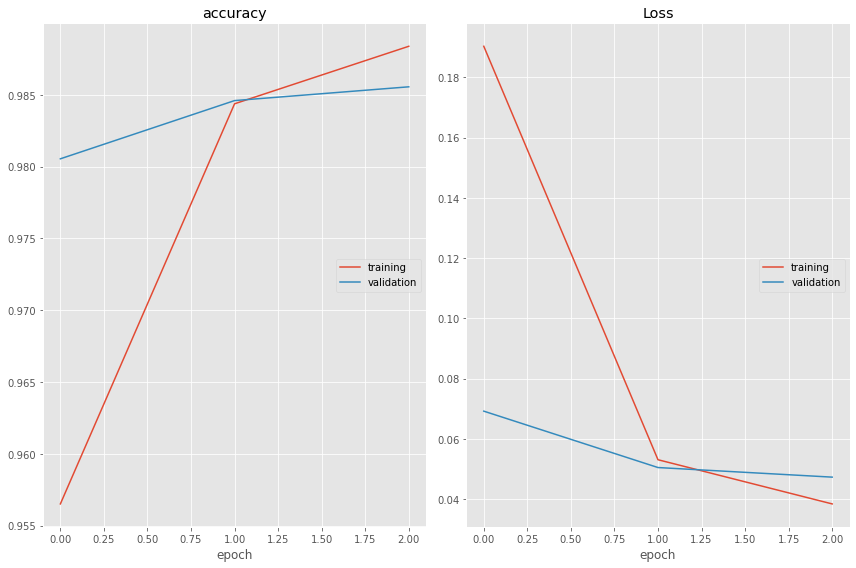

accuracy
	training         	 (min:    0.957, max:    0.988, cur:    0.988)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.038, max:    0.190, cur:    0.038)
	validation       	 (min:    0.047, max:    0.069, cur:    0.047)
1080/1080 [==============================] - 109s 101ms/step - loss: 0.0384 - accuracy: 0.9884 - val_loss: 0.0473 - val_accuracy: 0.9856


In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

In [29]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 13ms/step - loss: 0.0492 - accuracy: 0.9851


[0.04916999861598015, 0.9851126074790955]

In [30]:
x_test[0]

array([ 7445,  5086, 31032, 33447, 29154,  5717, 31032,  3074,  5864,
       11835,  5780,  6806,  5864, 34209, 31421, 15580, 23697, 13185,
       31032, 23697, 15801, 29835,  7328,  8174, 28883, 32837,  5864,
       20314,  6268, 27607, 16068, 29835, 23697, 29239, 34781, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [31]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))

Word           True 	Pred

------------------------------
Nepalese       B-gpe	B-gpe
police         O	O
detained       O	O
41             O	O
Tibetans       B-gpe	B-gpe
Sunday         B-tim	B-tim
for            O	O
illegal        O	O
entry          O	O
into           O	O
the            O	O
country        O	O
.              O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon           O	O
upon  